In [ ]:
# By line: FGL 2020-08-26, adapted from F.L. 2020-07-16 https://wiki.ucar.edu/display/MUSICA/Plot+output+with+Python
# Script aims to:
# - Load an unstructured netCDF file
# - Define a fixed grid for visualization
# - Define a function to plot using Labert-Conformal projection
# - Define a function to interpolate unstructured to fixed grid data 
# - Regrid and create contour plot of variable over CONUS
# - Overlay a set of surface observations on the contour plot 

In [38]:
# At the start of a Jupyter notebook you need to import all modules that you will use
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [39]:
# While many files contain the unstructured grid data, some may not so we have separated the lat/lon into files here
grid_dir = "~/Documents/TemporaryFiles/CAMchemSERR_validation/emis_res_exp/files/"
rr_grid = "emissions-NEI_grid_proxy.nc"
nc_rrgrid = xr.open_dataset(grid_dir+rr_grid)
lat = nc_rrgrid['lat']
lon = nc_rrgrid['lon']

In [40]:
#Define the directories and file of interest for your results. This can be shortened to less lines as well.
result_dir = "~/Documents/TemporaryFiles/CAMchemSERR_validation/emis_res_exp/files/"
file = "opt_se_cslam_nov2019.FCHIST.ne0CONUSne30x8_ne0CONUSne30x8_mt12_pecount2700_SEACRS_TS1_CAMS_final_2013_branch.cam.h0.2013_pm_vert.nc"
#the netcdf file is now held in an xarray dataset named 'nc' and can be referenced later in the notebook
nc = xr.open_dataset(result_dir+file)

In [41]:
#Define the lat/lon grid we will be putting results on for plotting. Here this is 0.1 by 0.1.
x = np.linspace(210,310,1001)
y =  np.linspace(0,70,701)
X, Y = np.meshgrid(x,y)

In [42]:
#In order to plot a number of variables easily with less code we define the plotting routine as a function
def plot_map_LCC(data, lat, lon, llim, ulim, units):
    #if you want to change the figure size of map projection you can do it here
    fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=ccrs.LambertConformal()))
    #this is the actual plotting routine, using pcolormesh. Most variables are inputs from the function call
    im = ax.pcolormesh(lon,lat,data,cmap='Spectral_r',vmin=llim, vmax=ulim, transform=ccrs.PlateCarree())
    #this is for visualization of administrative boundaries. Many shapes included in the 'Natural Earth' library can also be used
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, edgecolor='#D3D3D3')
    cb = fig.colorbar(im, ax=ax)
    cb.set_label(units)
    return fig, ax

In [43]:
#Similarly we use a function to define the regridding routine from unstructured to fixed-grid
def grid_musica(var, time, lev):
    nctmp = nc.isel(time=time, lev=lev)
    vartmp = nctmp[var]
    X, Y = np.meshgrid(x,y)
    grid_var = griddata((lon,lat), vartmp, (X, Y), method='linear')
    return grid_var

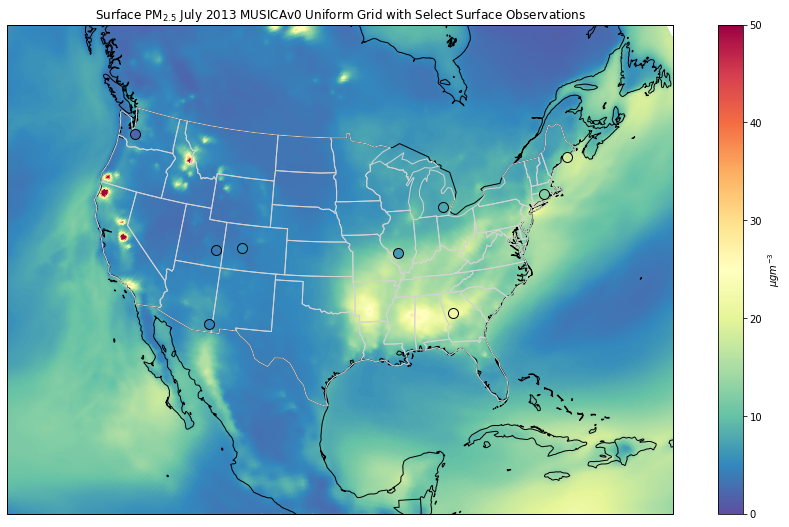

In [45]:
#Here we use the previous defined function to regrid surface PM2.5 from unstructured model output to interpolated 0.1x0.1
grid_plot = grid_musica('PM25',7,31)
grid_plot = grid_plot*10**9

#We then use the plotting function defined above to plot the output on a Lambert-Conformal projection
fig, ax = plot_map_LCC(grid_plot,Y,X,0,50,'$\mu g m^{-3}$')
#we will zoom in slightly on the extents that are defined based on map projection
ax.set_extent([-32e5, 32e5, -25e5, 22e5], crs=ccrs.LambertConformal())
plt.title("Surface PM$_{2.5}$ July 2013 MUSICAv0 Uniform Grid with Select Surface Observations")

#Now lets look at the sufrace plot again, but this time add markers for observations at several points.
#first we need to define our observational data into an array
#this can also be imported from text files using various routines
latpt = np.array([41.8408,44.377,38.8689,42.4164,38.458,32.0097,33.1792,38.9573,46.761,37.711])
lonpt = np.array([-72.0111,-68.261,-89.6219,-83.9019,-109.821,-109.389,-84.4053,-106.985,-122.121,-119.704])
lonpt = lonpt + 360
obs_pm = np.array([12.3,18.2,6.5,7.8,3.7,4.8,22.1,5.4,2.0,5.7])
#this is needed for convert the observation to the position on the basemap color gradient defined above
color_arr  = (obs_pm)/50

#this defines the colormap we will be using, where '_r' specifies the reverse 
#For more colormaps visit: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
cmap = plt.cm.get_cmap('Spectral_r')

#to specify the color of each point it is easiest plot individual points in a loop
for i in range(9):
   ax.plot(lonpt[i], latpt[i], linestyle='none', marker="o", markersize=10, alpha=1, c=cmap(color_arr[i]), markeredgecolor="black", markeredgewidth=1,transform=ccrs.PlateCarree())